## Introduction and Business Question

Implementation of seasonal flu vaccination programs play a substantial role in public health. However, in 2022, only 49% of adults are planning on obtaining a flu vaccine, despite the risks posed in forgoing it. The purpose of this project is to understand which demographics are least likely to get a flu vaccine, in order for officials to better target those demographics and utilize limited marketing resources to expanding the percentage of the population that chooses to be vaccinated. 

The models built in this project will attempt to classify whether or not an individual is likely to be vaccinated based on collected demographic data. The models will be assessed on an overall accuracy score - whether or not an individual's tendency was correctly predicted. Though the more important target in the scope of public health would be to err on the side of conservativeness - it is better to be wrong about a person not getting the vaccine than actually thinking they will get it - the business problem here is to assess what demographics should be targeted as predictors of not getting a seasonal flu vaccine. 

## Data Cleaning and Exploration

The data set used in this business is a survey of demographic information for 26,707 individuals and their decision to be vaccinated for either the H1H1 or seasonal flu vaccine. This project will focus solely on the seasonal flu vaccine. 

In [1]:
# import packages
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier,plot_importance

In [2]:
# import and examine data
df = pd.read_csv('training_set_features.csv')
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [3]:
df.shape

(26707, 36)

In [4]:
# import training labels
labels = pd.read_csv('labels.csv')
labels.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [6]:
# extract target column from training labels
target = labels['seasonal_vaccine']
target.value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

From looking at the distribution of the target variable, we see that the split is nearly even (considering the amount of data we have) - therefore, at this time we do not need to worry about class imbalance problems that would appear if one class of data was far more frequent than the other.

In [7]:
# merge dataframes for the purpose of EDA - makes easier to manipulate data set without losing rows
df['seasonal_vaccine'] = labels['seasonal_vaccine']
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0


In [8]:
# examine data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

From looking at the features above, and from examining the source descriptions of the features , we can remove some of the features from the start, specifically those that are related to the H1N1 virus and not the seasonal flu. Additionally, we can remove the respondent_id feature as this will not be used for predictive reasons.

Feature documentation at this link: https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/#labels

In [9]:
drop_columns = ['respondent_id','h1n1_concern','h1n1_knowledge','doctor_recc_h1n1','opinion_h1n1_vacc_effective',
                'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc','hhs_geo_region','employment_industry',
                'employment_occupation']
df = df.drop(columns=drop_columns,axis=1)

Now that we have the features we want to be working with, we can look for missing values and decide how to deal with them.

In [10]:
df.isna().sum()

behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
census_msa                         0
household_adults                 249
household_children               249
seasonal_vaccine                   0
d

The only two continuous variables in the features are number of adults and children outside of the household that an individual is exposed to. Because the missing values in those columns are a very small percentage of the data set, we can just drop those values. For the rest of the features, which are categorical, we are better off treating the missing values as their own category, so we can replace those missing values with a label denoting as such.

In [11]:
# remove rows with missing household_adults and household_children values
missing_household_adults = df[df['household_adults'].isnull()].index.tolist()
missing_household_children = df[df['household_children'].isnull()].index.tolist()
combined = list(set(missing_household_adults+missing_household_children))
df.drop(combined,axis=0,inplace=True)

In [12]:
# confirm no missing values in household_adults and household_children features
df.isna().sum()

behavioral_antiviral_meds         69
behavioral_avoidance             204
behavioral_face_mask              19
behavioral_wash_hands             41
behavioral_large_gatherings       85
behavioral_outside_home           82
behavioral_touch_face            127
doctor_recc_seasonal            2097
chronic_med_condition            777
child_under_6_months             595
health_worker                    588
health_insurance               12029
opinion_seas_vacc_effective      350
opinion_seas_risk                386
opinion_seas_sick_from_vacc      394
age_group                          0
education                       1170
race                               0
sex                                0
income_poverty                  4181
marital_status                  1172
rent_or_own                     1804
employment_status               1225
census_msa                         0
household_adults                   0
household_children                 0
seasonal_vaccine                   0
d

In [13]:
# replace the rest of the missing values with a label
df.fillna('missing',inplace=True)

In [14]:
# confirm no more missing values
df.isna().sum()

behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
census_msa                     0
household_adults               0
household_children             0
seasonal_vaccine               0
dtype: int64

In [16]:
# check new data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26458 entries, 0 to 26706
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26458 non-null  object 
 1   behavioral_avoidance         26458 non-null  object 
 2   behavioral_face_mask         26458 non-null  object 
 3   behavioral_wash_hands        26458 non-null  object 
 4   behavioral_large_gatherings  26458 non-null  object 
 5   behavioral_outside_home      26458 non-null  object 
 6   behavioral_touch_face        26458 non-null  object 
 7   doctor_recc_seasonal         26458 non-null  object 
 8   chronic_med_condition        26458 non-null  object 
 9   child_under_6_months         26458 non-null  object 
 10  health_worker                26458 non-null  object 
 11  health_insurance             26458 non-null  object 
 12  opinion_seas_vacc_effective  26458 non-null  object 
 13  opinion_seas_ris

As expected, with the exception of 'household_adults' and 'household_children,' the features are now object types, as they were previously binary integers and now have the possibility of containing the string 'missing.'

In [17]:
vaccine_rate_by_age = pd.DataFrame(df.groupby(['age_group']).sum()['seasonal_vaccine']/df['age_group'].value_counts())
vaccine_rate_by_age

,0
18 - 34 Years,0.285152
35 - 44 Years,0.364191
45 - 54 Years,0.402692
55 - 64 Years,0.511419
65+ Years,0.673780


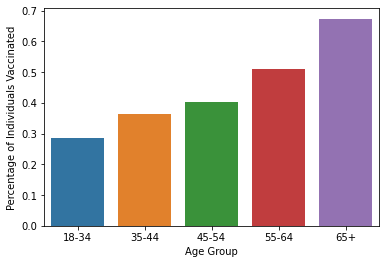

In [18]:
# plot vaccination rate by age group
sns.barplot(x=['18-34','35-44','45-54','55-64','65+'],
             y=df.groupby(['age_group']).sum()['seasonal_vaccine']/df['age_group'].value_counts())
plt.xlabel('Age Group')
plt.ylabel('Percentage of Individuals Vaccinated');

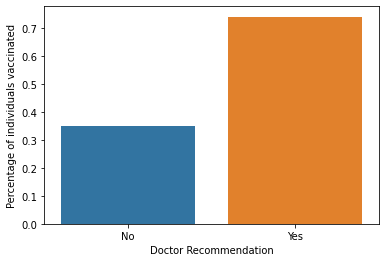

In [223]:
# plot vaccination rate by age doctor recommendation
sns.barplot(x=['No','Yes'],
             y=(df.groupby(['doctor_recc_seasonal']).sum()['seasonal_vaccine']/df['doctor_recc_seasonal'].value_counts())[0:2])
plt.xlabel('Doctor Recommendation')
plt.ylabel('Percentage of individuals vaccinated');

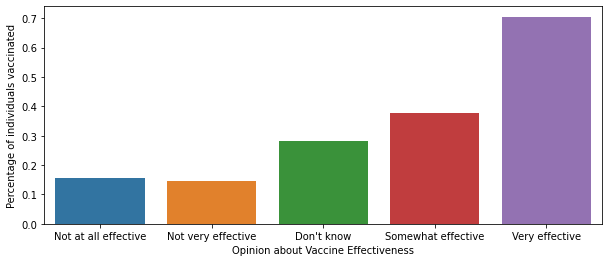

In [284]:
# plot vaccination rate by opinion of vaccine effectiveness
f,ax = plt.subplots(figsize=(10,4))
sns.barplot(x=['Not at all effective','Not very effective',"Don't know",'Somewhat effective','Very effective'],
            y=(df.groupby(['opinion_seas_vacc_effective']).sum()['seasonal_vaccine']/df['opinion_seas_vacc_effective'].value_counts())[0:5])
plt.xlabel('Opinion about Vaccine Effectiveness')
plt.ylabel('Percentage of individuals vaccinated');

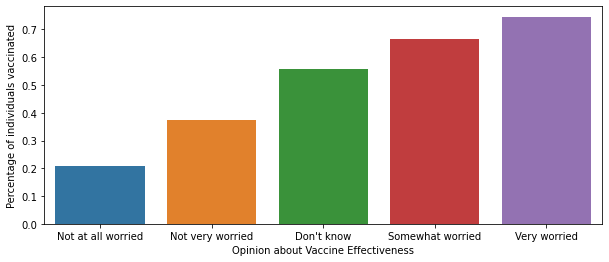

In [26]:
# plot vaccination rate by opinion of flu risk
f,ax = plt.subplots(figsize=(10,4))
sns.barplot(x=['Not at all worried','Not very worried',"Don't know",'Somewhat worried','Very worried'],
            y=(df.groupby(['opinion_seas_risk']).sum()['seasonal_vaccine']/df['opinion_seas_risk'].value_counts())[0:5])
plt.xlabel('Opinion about flu risk')
plt.ylabel('Percentage of individuals vaccinated');

## Data Scaling and Splitting

Before constructing the models, there are a few more pre-processing steps that must occur. First, the data needs to be split into training and test sets. This allows the models to be fit and optimized (via cross-validation) using the training set, while withholding some of the data to test the final models on. Once this split is done, the categorical data must be encoded as dummy variables, and then the data must be scaled to account for the numerical variables. This needs to be done after the train / test split to ensure there is no leakage between the partitioned data.

In [19]:
# split into features and target variable
y = df['seasonal_vaccine']
X = df.drop('seasonal_vaccine',axis=1)

In [20]:
# perform the train test split on the data
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21166, 26)
(5292, 26)
(21166,)
(5292,)


In [21]:
# encode categorical variables in training data
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train_columns = X_train.columns
X_test_columns = X_train.columns

print(X_train.shape)
print(X_test.shape)

(21166, 89)
(5292, 89)


In [22]:
# scale training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled,columns=X_train_columns)
X_train.head()

,household_adults,household_children,behavioral_antiviral_meds_0.0,behavioral_antiviral_meds_1.0,behavioral_antiviral_meds_missing,behavioral_avoidance_0.0,behavioral_avoidance_1.0,behavioral_avoidance_missing,behavioral_face_mask_0.0,behavioral_face_mask_1.0,...,rent_or_own_Own,rent_or_own_Rent,rent_or_own_missing,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_missing,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
0,0.15027,0.501978,-4.327355,4.458000,-0.05287,-0.612041,0.624451,-0.089982,0.271391,-0.269581,...,0.646945,-0.541928,-0.270185,-1.020719,1.258593,-0.242984,-0.2221,-0.883092,-0.644888,1.652178
1,2.80743,-0.575158,0.231088,-0.224316,-0.05287,-0.612041,0.624451,-0.089982,0.271391,-0.269581,...,0.646945,-0.541928,-0.270185,-1.020719,-0.794538,4.115494,-0.2221,-0.883092,-0.644888,1.652178
2,0.15027,-0.575158,0.231088,-0.224316,-0.05287,-0.612041,0.624451,-0.089982,0.271391,-0.269581,...,0.646945,-0.541928,-0.270185,0.979701,-0.794538,-0.242984,-0.2221,-0.883092,-0.644888,1.652178
3,-1.17831,-0.575158,0.231088,-0.224316,-0.05287,-0.612041,0.624451,-0.089982,0.271391,-0.269581,...,0.646945,-0.541928,-0.270185,0.979701,-0.794538,-0.242984,-0.2221,1.132384,-0.644888,-0.605262
4,-1.17831,-0.575158,0.231088,-0.224316,-0.05287,1.633878,-1.601406,-0.089982,0.271391,-0.269581,...,-1.545727,1.845263,-0.270185,0.979701,-0.794538,-0.242984,-0.2221,1.132384,-0.644888,-0.605262


In [23]:
# scale test data
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled,columns=X_test_columns)
X_test.head()

,household_adults,household_children,behavioral_antiviral_meds_0.0,behavioral_antiviral_meds_1.0,behavioral_antiviral_meds_missing,behavioral_avoidance_0.0,behavioral_avoidance_1.0,behavioral_avoidance_missing,behavioral_face_mask_0.0,behavioral_face_mask_1.0,...,rent_or_own_Own,rent_or_own_Rent,rent_or_own_missing,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_missing,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
0,-1.17831,-0.575158,0.231088,-0.224316,-0.05287,-0.612041,0.624451,-0.089982,0.271391,-0.269581,...,0.646945,-0.541928,-0.270185,0.979701,-0.794538,-0.242984,-0.2221,-0.883092,-0.644888,1.652178
1,1.47885,-0.575158,0.231088,-0.224316,-0.05287,1.633878,-1.601406,-0.089982,0.271391,-0.269581,...,-1.545727,1.845263,-0.270185,0.979701,-0.794538,-0.242984,-0.2221,1.132384,-0.644888,-0.605262
2,0.15027,1.579114,0.231088,-0.224316,-0.05287,1.633878,-1.601406,-0.089982,0.271391,-0.269581,...,0.646945,-0.541928,-0.270185,0.979701,-0.794538,-0.242984,-0.2221,1.132384,-0.644888,-0.605262
3,0.15027,-0.575158,0.231088,-0.224316,-0.05287,-0.612041,0.624451,-0.089982,0.271391,-0.269581,...,0.646945,-0.541928,-0.270185,-1.020719,1.258593,-0.242984,-0.2221,-0.883092,-0.644888,1.652178
4,0.15027,1.579114,0.231088,-0.224316,-0.05287,-0.612041,0.624451,-0.089982,0.271391,-0.269581,...,-1.545727,1.845263,-0.270185,-1.020719,1.258593,-0.242984,-0.2221,-0.883092,-0.644888,1.652178


## Model Building and Evaluation

Now that the data has been cleaned and prepared for modeling, we can begin the process of building multiple models. The process for building the models will be as follows:
1. Initialize a model with default system parameters (with the exception of random_state, which will be included in each for reproducability)
2. Get the 5-fold cross-validation score for the default model using the training set; five folds is used on this data-set because of the large number of observations.
3. Perform a parameter grid-search with 3-fold cross-validation (we use less folds here because of computation time) on the training set repeatedly until a satisfactory parameter set is found. 
4. Get the 5-fold cross-validation score for the final model on the training set, for comparison with the default model.
5. Get the reportable validation scores for the final model on the testing set.

The nature of this project raises the question of what the appropriate reportable score is. In doing so, we will look at three scores:
* Accuracy score: this is simply the percentage of correct predictions versus total predictions (i.e. size of the test set) that the model makes. Since we are looking for a model that has strong predictive value, this is a good baseline score to be using.
* F1 score: this score is the harmonic mean of precision (of all individuals predicted to be vaccinated, how many were actually vaccinated) and recall (of all individuals vaccinated, which ones were guessed correctly). Although for the sake of public health, we are more bothered by false positives than false negatives, the F1 score appropriately balances both accuracy and a desire to not have a high false positive rate.

### Model 1: Logistic Regression

In [24]:
# initialize logistic regression
log_reg = LogisticRegression(solver='liblinear',C=1e16,fit_intercept=False,random_state=42)
log_reg.fit(X_train,y_train)

LogisticRegression(C=1e+16, fit_intercept=False, random_state=42,
                   solver='liblinear')

In [25]:
# 5-fold cross validation on training set
np.mean(cross_val_score(log_reg,X_train,y_train,cv=5))

0.7769537010472076

In [73]:
# first param grid search
params_log_reg_1 = ({'C':[1,1000,10000,1e16],
                     'solver':['liblinear','newton-cg','lbfgs'],
                     'fit_intercept':[True,False]})

log_reg_gs_1 = GridSearchCV(log_reg,params_log_reg_1,cv=3)
log_reg_gs_1.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(C=1e+16, fit_intercept=False,
                                          random_state=42, solver='liblinear'),
             param_grid={'C': [1, 1000, 10000, 1e+16],
                         'fit_intercept': [True, False],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs']})

In [74]:
log_reg_gs_1.best_params_

{'C': 1000, 'fit_intercept': True, 'solver': 'liblinear'}

In [75]:
log_reg_gs_1.best_score_

0.7781821229161009

In [78]:
# second param grid search
params_log_reg_2 = ({'C':[1,100,1000,5000],
                     'solver':['liblinear','newton-cg','lbfgs'],
                     'fit_intercept':[True,False]})

log_reg_gs_2 = GridSearchCV(log_reg,params_log_reg_2,cv=3)
log_reg_gs_2.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(C=1e+16, fit_intercept=False,
                                          random_state=42, solver='liblinear'),
             param_grid={'C': [1, 100, 1000, 5000],
                         'fit_intercept': [True, False],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs']})

In [79]:
log_reg_gs_2.best_params_

{'C': 100, 'fit_intercept': True, 'solver': 'liblinear'}

In [80]:
log_reg_gs_2.best_score_

0.7781821229161009

Given minimal improvement between the first two grid searches, we can use the results of the second grid search for our final model.

In [81]:
# initialize final model
log_reg_final = LogisticRegression(solver='liblinear',C=100,fit_intercept=True,random_state=42)
log_reg_final.fit(X_train,y_train)

LogisticRegression(C=100, random_state=42, solver='liblinear')

In [82]:
# five fold cross validation score
np.mean(cross_val_score(log_reg_final,X_train,y_train,cv=5))

0.7778041840316893

In [108]:
# get training scores
log_reg_final_pred = log_reg_final.predict(X_test)
log_reg_final_acc = round(accuracy_score(log_reg_final_pred,y_test),4)
log_reg_final_f1 = round(f1_score(log_reg_final_pred,y_test),4)

print('Test accuracy score:',log_reg_final_acc)
print('Test F1 score:',log_reg_final_f1)

Test accuracy score: 0.7806
Test F1 score: 0.7643


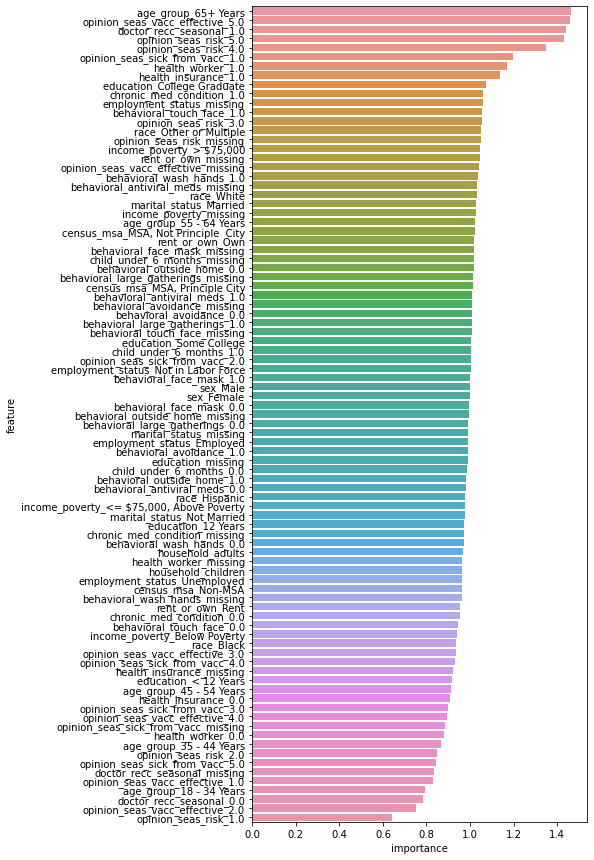

In [229]:
# plot feature importance
feature_importance = pd.DataFrame(data={'feature':X_train.columns,'importance':pow(math.e,log_reg.coef_[0])}).sort_values(by='importance',
                                                                                                                       ascending=False)
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(x="importance", y="feature", data=feature_importance,orient='h');

### Model 2: Decision Tree

In [93]:
# initialize ridge regression
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [94]:
# 5-fold cross validation on training set
np.mean(cross_val_score(tree,X_train,y_train,cv=5))

0.6713130774787165

In [96]:
# first param grid search
params_tree_1 = ({'max_depth':[None,5,15],
                  'min_samples_split':[2,5,10],
                  'min_samples_leaf':[1,2,5],
                  'max_features':['auto','sqrt','log2']})

tree_gs_1 = GridSearchCV(tree,params_tree_1,cv=3)
tree_gs_1.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]})

In [97]:
tree_gs_1.best_params_

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [98]:
tree_gs_1.best_score_

0.7268734468352266

In [99]:
# second param grid search
params_tree_2 = ({'max_depth':[None,5,15,20],
                  'min_samples_split':[2,5],
                  'min_samples_leaf':[2,5,10],
                  'max_features':['auto','sqrt','log2']})

tree_gs_2 = GridSearchCV(tree,params_tree_2,cv=3)
tree_gs_2.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 15, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [2, 5]})

In [100]:
tree_gs_2.best_params_

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2}

In [101]:
tree_gs_2.best_score_

0.7397716047597084

In [102]:
# third param grid search
params_tree_3 = ({'max_depth':[None,5,15,20],
                  'min_samples_split':[2],
                  'min_samples_leaf':[2,5,10,20],
                  'max_features':['auto','sqrt','log2']})

tree_gs_3 = GridSearchCV(tree,params_tree_3,cv=3)
tree_gs_3.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 15, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 5, 10, 20],
                         'min_samples_split': [2]})

In [103]:
tree_gs_3.best_params_

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2}

Since there is no difference in parameter choice between the second and third grid searches, we will treat those as the final parameters for the model.

In [105]:
# initialize final model
tree_final = DecisionTreeClassifier(random_state=42,max_depth=15,max_features='auto',min_samples_leaf=10,
                                   min_samples_split=2)
tree_final.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=15, max_features='auto', min_samples_leaf=10,
                       random_state=42)

In [106]:
# five fold cross validation score
np.mean(cross_val_score(tree_final,X_train,y_train,cv=5))

0.7403858564101637

In [117]:
# get test scores
tree_final_pred = tree_final.predict(X_test)
tree_final_acc = round(accuracy_score(tree_final_pred,y_test),4)
tree_final_f1 = round(f1_score(tree_final_pred,y_test),4)

print('Test accuracy score:',tree_final_acc)
print('Test F1 score:',tree_final_f1)

Test accuracy score: 0.7413
Test F1 score: 0.7178


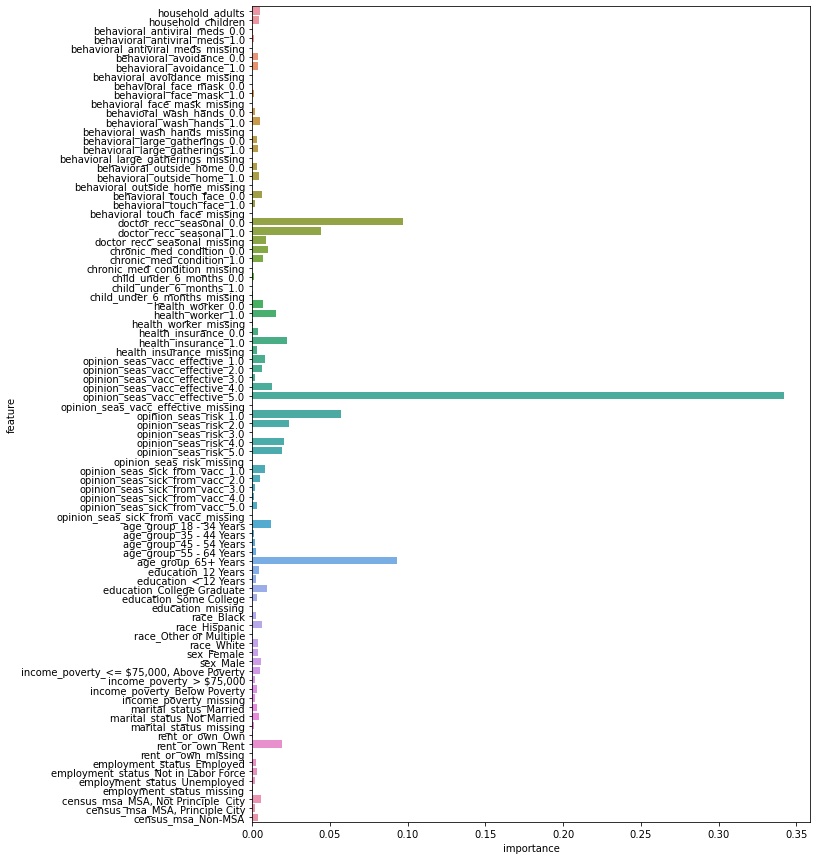

In [114]:
# feature importance chart
feature_importance_tree = pd.DataFrame({'feature':X_train.columns,'importance':tree_final.feature_importances_})

f,ax = plt.subplots(figsize=(10,15))
sns.barplot(x='importance',y='feature',data=feature_importance_tree,orient='h');

### Model 3: Random Forest

With the logistic regression model as a baseline for accuracy, a slightly more complex model might be in order. A random forest model makes use of multiple decision trees, but accounts for the variance in the model by limiting the number of features used in each tree as well as its depth. Because random forests have far more tunable parameters than simple logistic regressions, multiple grid searches will have to be used to tune the parameters fully.

In [111]:
# initialize random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [112]:
# 5-fold cross validation on training set
np.mean(cross_val_score(rf,X_train,y_train,cv=5))

0.7674574817093264

The initial random forest, with default parameters, has roughly the same accuracy score as the logistic regression. To see if this can be improved upon, we must utilize grid searching of parameters to account for the fact that they are tuned simultaneously, which can affect results.

In [ ]:
# first grid search
params_rf_1 = ({'n_estimators':[30,50,100],
                'criterion':['gini', 'entropy'],
                'max_depth':[None,2,10],
                'min_samples_split':[2,10,15],
                'min_samples_leaf':[2,10,15]})

rf_gs_1 = GridSearchCV(rf,params_rf_1,cv=3)
rf_gs_1.fit(X_train,y_train)

In [ ]:
rf_gs_1.best_params_

In [ ]:
rf_gs_1.best_score_

The first grid search used three folds, despite the large data size, to reduce the runtime given the number of parameters we are trying to tune. The first parameter to modify for the next grid search is the number of estimators, since we have modified it most from the default value.

In [ ]:
# second grid search
params_rf_2 = ({'n_estimators':[50,100,150],
                'criterion':['gini', 'entropy'],
                'max_depth':[None,2,10],
                'min_samples_split':[2,10,15],
                'min_samples_leaf':[2,10,15]})

rf_gs_2 = GridSearchCV(rf,params_rf_2,cv=3)
rf_gs_2.fit(X_train,y_train)

In [ ]:
rf_gs_2.best_params_

In [ ]:
rf_gs_2.best_score_

In [ ]:
# third grid search
params_rf_3 = ({'n_estimators':[80,100,130],
                'criterion':['gini', 'entropy'],
                'max_depth':[None,2,10],
                'min_samples_split':[10,15,20],
                'min_samples_leaf':[2,5]})

rf_gs_3 = GridSearchCV(rf,params_rf_3,cv=3)
rf_gs_3.fit(X_train,y_train)

In [ ]:
rf_gs_3.best_params_

In [ ]:
rf_gs_3.best_score_

In [ ]:
# fourth grid search
params_rf_4 = ({'n_estimators':[100,130,150],
                'criterion':['gini', 'entropy'],
                'max_depth':[None,2,10],
                'min_samples_split':[15,20,30],
                'min_samples_leaf':[2,5]})

rf_gs_4 = GridSearchCV(rf,params_rf_4,cv=3)
rf_gs_4.fit(X_train,y_train)

In [ ]:
rf_gs_4.best_params_

In [ ]:
rf_gs_4.best_score_

In [ ]:
# fifth grid search
params_rf_5 = ({'n_estimators':[130,150,200],
                'criterion':['gini', 'entropy'],
                'max_depth':[None,10],
                'min_samples_split':[15,20,25],
                'min_samples_leaf':[2,5]})

rf_gs_5 = GridSearchCV(rf,params_rf_5,cv=3)
rf_gs_5.fit(X_train,y_train)

In [ ]:
rf_gs_5.best_params_

In [ ]:
rf_gs_5.best_score_

In [ ]:
# sixth grid search
params_rf_6 = ({'n_estimators':[150,200,250],
                'criterion':['gini', 'entropy'],
                'max_depth':[None],
                'min_samples_split':[20,25,30],
                'min_samples_leaf':[2]})

rf_gs_6 = GridSearchCV(rf,params_rf_6,cv=3)
rf_gs_6.fit(X_train,y_train)

In [ ]:
rf_gs_6.best_params_

In [ ]:
rf_gs_6.best_score_

After six grid searches, the optimizer has come close to appropriate parameters. To finalize the search, the cross-validation folds will be increased and parameter ranges narrowed further.

In [ ]:
# seventh grid search
params_rf_7 = ({'n_estimators':[180,200,230],
                'criterion':['gini', 'entropy'],
                'max_depth':[None],
                'min_samples_split':[22,25,28],
                'min_samples_leaf':[2]})

rf_gs_7 = GridSearchCV(rf,params_rf_7,cv=3)
rf_gs_7.fit(X_train,y_train)

In [ ]:
rf_gs_7.best_params_

In [ ]:
rf_gs_7.best_score_

In [ ]:
# eigth grid search
params_rf_8 = ({'n_estimators':[200,230,245],
                'criterion':['gini', 'entropy'],
                'max_depth':[None],
                'min_samples_split':[22,25,28],
                'min_samples_leaf':[2]})

rf_gs_8 = GridSearchCV(rf,params_rf_8,cv=3)
rf_gs_8.fit(X_train,y_train)

In [ ]:
rf_gs_8.best_params_

In [ ]:
rf_gs_8.best_score_

In [ ]:
# ninth grid search
params_rf_9 = ({'n_estimators':[220,230,240],
                'criterion':['gini', 'entropy'],
                'max_depth':[None],
                'min_samples_split':[23,25,27],
                'min_samples_leaf':[2]})

rf_gs_9 = GridSearchCV(rf,params_rf_9,cv=3)
rf_gs_9.fit(X_train,y_train)

In [ ]:
rf_gs_9.best_params_

In [ ]:
rf_gs_9.best_score_

In [ ]:
# tenth grid search
params_rf_10 = ({'n_estimators':[200,210,220,230],
                'criterion':['gini', 'entropy'],
                'max_depth':[None],
                'min_samples_split':[25],
                'min_samples_leaf':[2]})

rf_gs_10 = GridSearchCV(rf,params_rf_10,cv=3)
rf_gs_10.fit(X_train,y_train)

In [ ]:
rf_gs_10.best_params_

In [ ]:
rf_gs_10.best_score_

As expected, the final random forest model was not much of an improvement over the default one - the cross-validated accuracy increased from about 77% to 78%, which is not much better than the final logistic regression either. However, we can proceed to assess the results of the model and see what, if anything, is different from the logistic regression in terms of variable importance.

In [115]:
# initialize final model
rf_final = RandomForestClassifier(random_state=42,criterion='entropy',max_depth=None,min_samples_leaf=2,
                              min_samples_split=25,n_estimators=220)
rf_final.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       min_samples_split=25, n_estimators=220, random_state=42)

In [116]:
# five fold cross validation score
np.mean(cross_val_score(rf_final,X_train,y_train,cv=5))

0.778796499733687

In [118]:
# get test scores
rf_final_pred = rf_final.predict(X_test)
rf_final_acc = round(accuracy_score(rf_final_pred,y_test),4)
rf_final_f1 = round(f1_score(rf_final_pred,y_test),4)

print('Test accuracy score:',rf_final_acc)
print('Test F1 score:',rf_final_f1)

Test accuracy score: 0.7802
Test F1 score: 0.7647


Here we see an improvement in accuracy over the whole test set, and an accurary score on the test set that is in line with what we saw during cross-validation - so here we can also assume that the effect of overfitting is minimal, if anything.

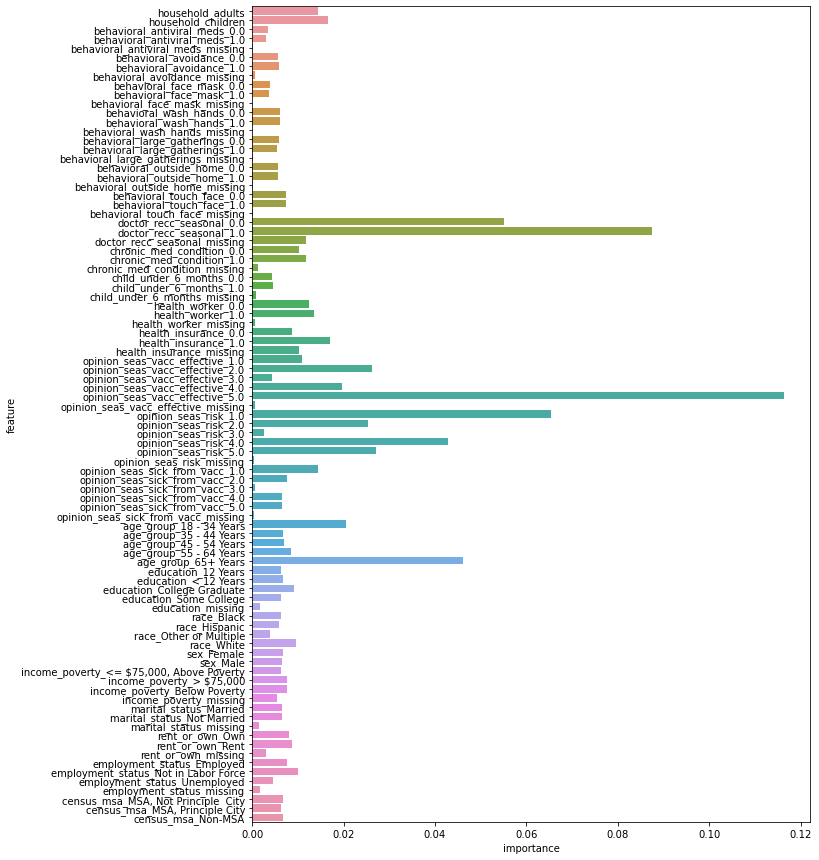

In [119]:
# feature importance chart
feature_importance_rf = pd.DataFrame({'feature':X_train.columns,'importance':rf_final.feature_importances_})

f,ax = plt.subplots(figsize=(10,15))
sns.barplot(x='importance',y='feature',data=feature_importance_rf,orient='h');

Somewhat unsurprisingly, the same features are important predictors in random forests as in logistic regression: doctor recommendation of a flu vaccine, 65+ age group, and a high opinion of vaccine effectiveness. Though this is not altogether surprising, it appears that maximizing the same predictors will lead to roughly the same outcomes and accuracy as logistic regression.

### Model 4: XGBoost

In [120]:
# create matrix of X_train and X_test to avoid model breaking over feature names
X_train_xg = np.matrix(X_train)
X_test_xg = np.matrix(X_test)

In [121]:
# initialize XGBoost 
clf = XGBClassifier(random_state=42)
clf.fit(X_train_xg,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [123]:
# 5-fold cross validation on training set
np.mean(cross_val_score(clf,X_train_xg,y_train,cv=5))

0.7725597993407403

We see from the default XGBoost model score that it is roughly in line with other models we have tried. So again, we will use model tuning to see if we can improve predict results on the test set.

From looking at the classifier documentation, there are a lot of parameters that can be modified. 

In [40]:
# first xgb grid search
params_xg_1 = {
    'learning_rate': [0.1,0.5,0.9],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [50,100,150],
}

xg_gs_1 = GridSearchCV(clf,params_xg_1,cv=3)
xg_gs_1.fit(X_train_xg,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=42,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
        

In [41]:
xg_gs_1.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 50,
 'subsample': 0.7}

In [42]:
xg_gs_1.best_score_

0.781631112953883

In [48]:
# second xgb grid search
params_xg_2 = {
    'learning_rate': [0.1,0.3],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [30,50,100],
}

xg_gs_2 = GridSearchCV(clf,params_xg_2,cv=3)
xg_gs_2.fit(X_train_xg,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=42,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
        

In [49]:
xg_gs_2.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 50,
 'subsample': 0.7}

In [50]:
xg_gs_2.best_score_

0.781631112953883

In [51]:
# third xgb grid search
params_xg_3 = {
    'learning_rate': [0.1,0.3],
    'max_depth': [6],
    'min_child_weight': [2,3],
    'subsample': [0.5, 0.7],
    'n_estimators': [30,50,80],
}

xg_gs_3 = GridSearchCV(clf,params_xg_3,cv=3)
xg_gs_3.fit(X_train_xg,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=42,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
        

In [52]:
xg_gs_3.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 50,
 'subsample': 0.7}

In [53]:
xg_gs_3.best_score_

0.781631112953883

With some of the initial parameter options converging quickly, the next step is to try to increase the max depth of the trees, which is more time intensive.

In [54]:
# fourth xgb grid search
params_xg_4 = {
    'learning_rate': [0.1],
    'max_depth': [6,10,15],
    'min_child_weight': [2],
    'subsample': [0.7],
    'n_estimators': [30,50,80],
}

xg_gs_4 = GridSearchCV(clf,params_xg_4,cv=3)
xg_gs_4.fit(X_train_xg,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=42,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
        

In [55]:
xg_gs_4.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 50,
 'subsample': 0.7}

In [56]:
xg_gs_4.best_score_

0.781631112953883

At this point in the grid search process, results seem to have plateaued. Because of this, we will keep the parameters as found so far and try to search through a few more advanced parameters as the model allows.

In [62]:
# fifth xgb grid search
params_xg_5 = {
    'learning_rate': [0.1],
    'max_depth': [6],
    'min_child_weight': [2],
    'subsample': [0.7],
    'n_estimators': [50]
}

xg_gs_5 = GridSearchCV(clf,params_xg_5,cv=3)
xg_gs_5.fit(X_train_xg,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=42,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
        

In [63]:
xg_gs_5.best_params_

{'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 50,
 'subsample': 0.7}

In [61]:
xg_gs_5.best_score_

0.781631112953883

In [124]:
# initialize final model
xg_final = XGBClassifier(random_state=42,learning_rate=0.1,max_depth=6,min_child_weight=2,n_estimators=50,
                        subsample=0.7)
xg_final.fit(X_train_xg,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [125]:
# five fold cross validation score
np.mean(cross_val_score(xg_final,X_train_xg,y_train,cv=5))

0.7787019371492472

In [126]:
# get test scores
xg_final_pred = xg_final.predict(X_test_xg)
xg_final_acc = round(accuracy_score(xg_final_pred,y_test),4)
xg_final_f1 = round(f1_score(xg_final_pred,y_test),4)

print('Test accuracy score:',xg_final_acc)
print('Test F1 score:',xg_final_f1)

Test accuracy score: 0.7829
Test F1 score: 0.769


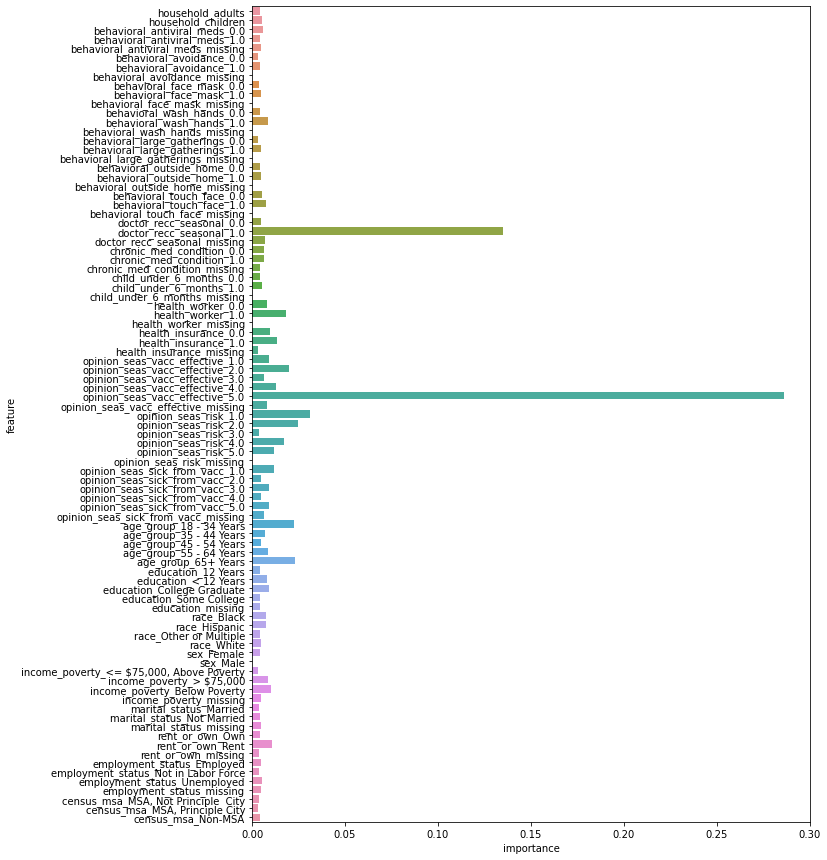

In [127]:
# feature importance chart
feature_importance_xg = pd.DataFrame({'feature':X_train.columns,'importance':xg_final.feature_importances_})

f,ax = plt.subplots(figsize=(10,15))
sns.barplot(x='importance',y='feature',data=feature_importance_xg,orient='h');

## Model Analysis and Business Recommendations

In [130]:
# create a dataframe of model names and results
model_names = ['Logistic Regression','Decision Tree','Random Forest','XGBoost']
acc_score = [log_reg_final_acc,tree_final_acc,rf_final_acc,xg_final_acc]
f1_score = [log_reg_final_f1,tree_final_f1,rf_final_f1,xg_final_f1]

In [133]:
results = pd.DataFrame({'model':model_names,'accuracy score':acc_score,'f1 score':f1_score})

In [136]:
results

,model,accuracy score,f1 score
0,Logistic Regression,0.7806,0.7643
1,Decision Tree,0.7413,0.7178
2,Random Forest,0.7802,0.7647
3,XGBoost,0.7829,0.7690


In [153]:
results_chart = pd.melt(results,id_vars='model',var_name='Score Type',value_name='Score')
results_chart

,model,Score Type,Score
0,Logistic Regression,accuracy score,0.7806
1,Decision Tree,accuracy score,0.7413
2,Random Forest,accuracy score,0.7802
3,XGBoost,accuracy score,0.7829
4,Logistic Regression,f1 score,0.7643
5,Decision Tree,f1 score,0.7178
6,Random Forest,f1 score,0.7647
7,XGBoost,f1 score,0.7690


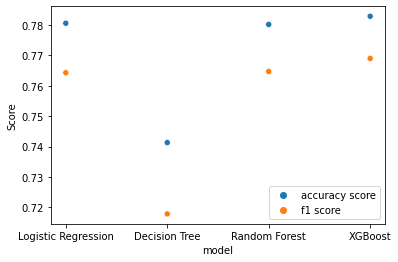

In [157]:
sns.scatterplot(x='model', y='Score', hue='Score Type', data=results_chart)
plt.legend(loc='lower right');

From the plot above, we can make two observations:
1. The decision tree is by far the worst model in terms of accuracy and F1 score, whereas the logistic regression, random forest, and XGBoost have very similar scores.
2. In the greater scheme, all of the scores are extremely similar, and this is reinforced by the feature importance plots of each model highlighting similar features - the bulk of the predictive work is done by a few important features, and it is hard to find value in the rest of them.

Even though it is marginal, we will use the XGBoost as the final selected model. To finalize which traits we will focus on, we can zoom in on feature importance and see what the final model suggests.

In [279]:
# feature importance chart for final XGBoost model
xg_feat = xg_final.get_booster().get_score(importance_type='gain')
temp = list(zip(*xg_feat.items()))
feature_num = [int(sample_str[1:]) for sample_str in temp[0]]

imp_feat = []
for n in feature_num:
    imp_feat.append(X_train.columns[n])

df_imp = pd.DataFrame({'Features':imp_feat,'Importance':temp[1]}).sort_values(by=['Importance'],ascending=False) 

In [280]:
df_imp.head()

,Features,Importance
0,opinion_seas_vacc_effective_5.0,263.325683
1,doctor_recc_seasonal_1.0,124.258266
2,opinion_seas_risk_1.0,28.899995
3,opinion_seas_risk_2.0,22.728006
5,age_group_65+ Years,21.346164


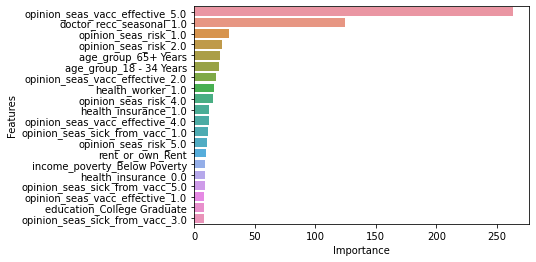

In [282]:
sns.barplot(x='Importance',y='Features',data=df_imp.head(20));